# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "cross-validated" simulated communities. Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy are different from those used for mock.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: exact match at level L
    * underclassification: lineage assignment is correct, but shorter than expected (e.g., not to species level)
    * misclassification: incorrect assignment
    
Where ``L`` = taxonomic level being tested


## Functions

In [1]:
from tax_credit.taxa_manipulator import *
from tax_credit.framework_functions import *
from tax_credit.eval_framework import heatmap_from_data_frame, parameter_comparisons, method_by_dataset

from os import path, makedirs, remove, rename
from os.path import expandvars, join
from IPython.display import display

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [2]:
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment")
analysis_name = "simulated-community"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*'))

This cell performs the classification evaluation and should not be modified.

In [3]:
if not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir,
                                                            summary_fp, test_type='cross-validated')
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_pallette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**match_ratio** = proportion of correct matches.

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [5]:
color_pallette = dict(rdp="seagreen", sortmerna="gray", uclust="blue")

level_results = extract_per_level_accuracy(accuracy_results)

y_vars = ["match_ratio"]

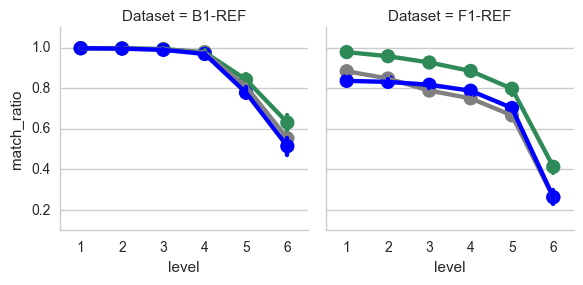

In [6]:
pointplot_from_data_frame(level_results, "level", y_vars,
                          group_by="Dataset", color_by="Method",
                          color_pallette=color_pallette)

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [7]:
result = per_level_kruskal_wallis(level_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Dataset     Variable             1             2             3  \
0  B1-REF  match_ratio  1.594208e-02  1.224681e-02  1.660126e-05   
1  F1-REF  match_ratio  1.616478e-17  1.503275e-13  2.538758e-11   

              4             5             6  
0  1.920218e-03  5.246523e-03  2.159270e-03  
1  3.935035e-10  6.511209e-09  1.100711e-07

## Heatmap of method accuracy by parameter

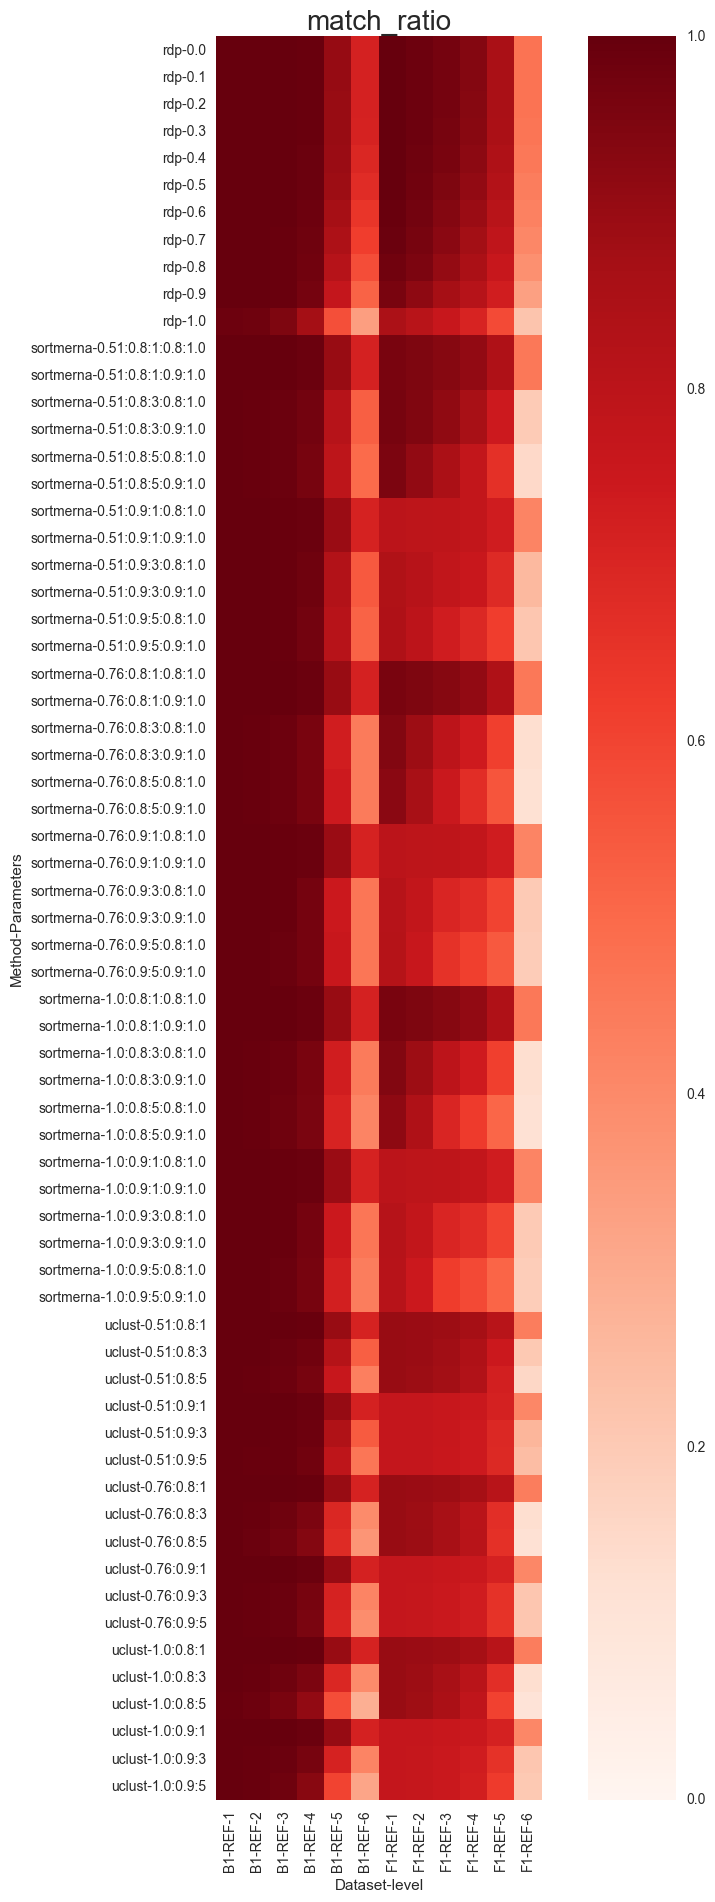

In [8]:
heatmap_from_data_frame(level_results, metric="match_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* column indicates how many samples a given method achieved within one mean absolute deviation of the best result (which is why they sum to more than the total number of samples).

In [9]:
for method in level_results['Method'].unique():
    top_params = parameter_comparisons(level_results, method, metrics=y_vars, 
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    print(method)
    display(top_params[:10])

rdp


match_ratio
0.0           29
0.1           29
0.2           29
0.3           29
0.4           29
0.5           26
0.6           24
0.7           24
0.8           24
0.9           22

sortmerna


match_ratio
0.51:0.8:1:0.8:1.0           30
0.76:0.8:1:0.9:1.0           30
1.0:0.8:1:0.9:1.0            30
1.0:0.8:1:0.8:1.0            30
0.51:0.8:1:0.9:1.0           30
0.76:0.8:1:0.8:1.0           30
0.51:0.8:3:0.8:1.0           24
0.51:0.8:3:0.9:1.0           24
0.51:0.8:5:0.8:1.0           22
0.51:0.8:5:0.9:1.0           22

uclust


match_ratio
0.51:0.8:1           30
0.76:0.8:1           30
1.0:0.8:1            30
1.0:0.9:1            26
0.76:0.9:1           26
0.51:0.9:1           26
0.51:0.8:3           25
0.51:0.8:5           25
0.76:0.8:3           24
0.76:0.8:5           24

Now we rank the top-performing method/parameter combination for each method from family to species level

In [10]:
for dataset in level_results['Dataset'].unique():
    for level in range(4,7):
        method_rank = method_by_dataset(level_results[level_results["level"] == level],
                                        dataset=dataset, sort_field='match_ratio',
                                        display_fields=("Method", "Parameters", "match_ratio"))
        print("{0} level {1}".format(dataset, level))
        display(method_rank)

B1-REF level 4


Method          Parameters  match_ratio
849   sortmerna  0.51:0.8:1:0.8:1.0     1.000000
1065     uclust          0.51:0.8:1     0.997468
801         rdp                 0.3     0.997468

B1-REF level 5


Method          Parameters  match_ratio
400        rdp                 0.1     0.917772
766     uclust           1.0:0.9:1     0.917772
574  sortmerna  0.76:0.9:1:0.9:1.0     0.915119

B1-REF level 6


Method          Parameters  match_ratio
923  sortmerna  0.76:0.8:1:0.8:1.0     0.729114
359     uclust           1.0:0.8:1     0.728814
5          rdp                 0.0     0.725989

F1-REF level 4


Method         Parameters  match_ratio
1569        rdp                0.1     0.955224
1779  sortmerna  1.0:0.8:1:0.9:1.0     0.919403
1455     uclust         0.51:0.8:1     0.883582

F1-REF level 5


Method          Parameters  match_ratio
1966        rdp                 0.2     0.879518
1246  sortmerna  0.51:0.8:1:0.9:1.0     0.850746
1492     uclust          0.76:0.8:1     0.838806

F1-REF level 6


Method          Parameters  match_ratio
1175        rdp                 0.0     0.486567
1241  sortmerna  0.51:0.8:1:0.8:1.0     0.477612
1529     uclust           1.0:0.8:1     0.468657